# Plot contour

Import Libraries

In [ ]:
import numpy as np                      # Data  
import pandas as pd                     # Data 
import matplotlib.pyplot as plt         # Plot
import yaml

Use Latex Font

In [ ]:
plt.rcParams.update({
    "text.usetex": True,                # Use LaTeX for text
    "font.family": "serif",             # Use 'serif' font
    "font.serif": ["Computer Modern"],  # LaTeX default font
    "axes.labelsize": 14,               # Font size for labels
    "font.size": 11,                    # General font size
    "legend.fontsize": 11,              # Font size for legend
    "xtick.labelsize": 10,              # Font size for x-axis
    "ytick.labelsize": 10               # Font size for y-axis
})

Import files

In [ ]:
cf_wind = pd.read_csv('../Data_Final/Verification/verification_cf_wind_1423.csv',
                      index_col = 0,
                      parse_dates = True
)

### Turbines

On an analysis of multiple turbines and their smoothing, we identify the Enercon.E112.4500 with 0.30w from renewables.ninja as the turbine with the best representation of EirGrid data

Read the Enercon Enercon.E112.4500 power curve and the smoothed version as well

In [ ]:
df_turbines_ninja_nosmoothing = pd.read_csv('../Data/renewables_ninja/Wind Turbine Power Curves ~ 5 (0.01ms with 0.00 w smoother).csv')
turbine_ninja_nosmoothing = {'hub_height':100, 'P':1., 'V':df_turbines_ninja_nosmoothing['speed'].values, 'POW':df_turbines_ninja_nosmoothing['Enercon.E112.4500'].values}

df_turbines_ninja_030smoothing = pd.read_csv('../Data/renewables_ninja/Wind Turbine Power Curves ~ 5 (0.01ms with 0.30 w smoother).csv')
turbine_ninja_030smoothing = {'hub_height':100, 'P':1., 'V':df_turbines_ninja_030smoothing['data$speed'].values, 'POW':df_turbines_ninja_030smoothing['Enercon.E112.4500'].values}

For C3S-Energy the wind turbine power curve is the following

In [ ]:
path_turbines_vestas = '../Data/power_curve_Vestas_V136_3450_c3se.yaml'
with open(path_turbines_vestas, 'r') as f:
    df_turbines_vestas = pd.json_normalize(yaml.safe_load(f))
    turbine_vestas = {'hub_height':100, 'P':1, 'V':np.array(df_turbines_vestas['V'].values[0]), 'POW':np.array(df_turbines_vestas['NPOW'].values[0])}

# Plot

Settings

In [ ]:
bins = np.arange(-0.01, 1.01, 0.02)

/tmp/ipykernel_6951/1409061311.py:57: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax[1].legend(custom_lines, labels=label_leg, fontsize=12, title='Area', title_fontproperties={'weight':'bold', 'size':12})


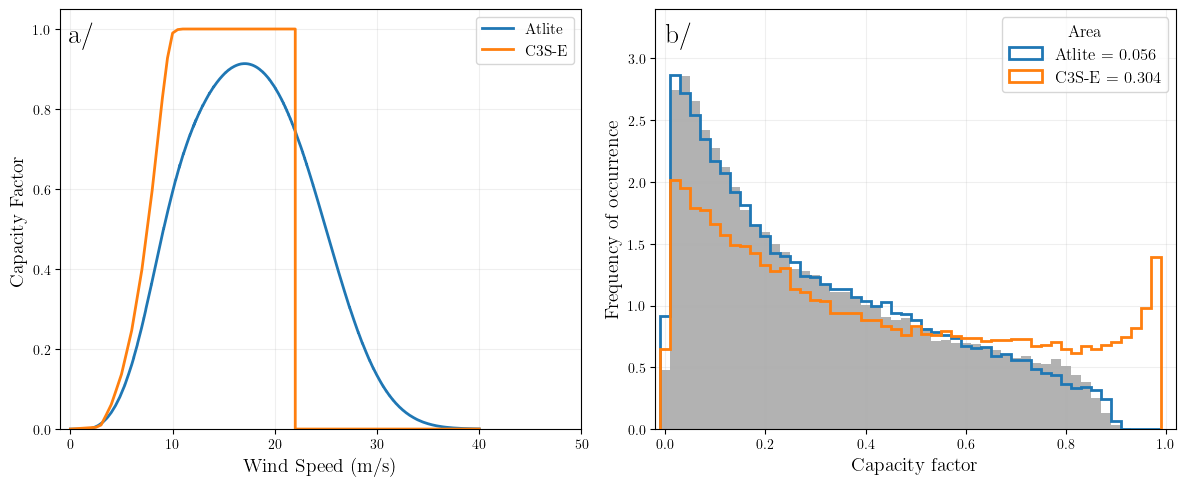

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(17,10))
ax[0].grid(alpha = 0.2, zorder = 0)
ax[1].grid(alpha = 0.2, zorder = 0)


# Left panel
ax[0].plot(turbine_ninja_030smoothing['V'], turbine_ninja_030smoothing['POW'],
           label = 'Atlite',
           lw = 2,
           zorder = 2
)
ax[0].plot(turbine_vestas['V'], turbine_vestas['POW'],
           label = 'C3S-E',
           lw = 2,
           zorder = 2
)

ax[0].set_xlim(-1,50)
ax[0].set_ylim(0)
ax[0].set_xlabel('Wind Speed (m/s)')
ax[0].set_ylabel('Capacity Factor')
ax[0].legend(ncol=1)


# Right panel
hist_eirgrid, _, _ = ax[1].hist(cf_eirgrid, bins=bins, 
                                density=True, color='k', 
                                alpha=0.3, zorder=1)
hist_030smooth, _, _ = ax[1].hist(cf_atlite, bins=bins, 
                                  density=True, 
                                  histtype='step', lw=2, 
                                  zorder=3)
hist_vestas, _, _ = ax[1].hist(cf_atlite_vestas, bins=bins, 
                               density=True, 
                               histtype='step', lw=2, 
                               zorder=3, color='C1')

ax[1].set_xlim(-0.02, 1.02)
ax[1].set_ylim(0, 3.4)
ax[1].set_xlabel('Capacity factor')
ax[1].set_ylabel('Frequency of occurrence')
ax[0].legend(ncol=1)

# Calculate Area under curve
total_area_030smooth = (abs(hist_030smooth - hist_eirgrid)*(bins[1:]-bins[:-1])).sum()
total_area_vestas = (abs(hist_vestas - hist_eirgrid)*(bins[1:]-bins[:-1])).sum()

custom_lines = [
    Line2D([0], [0], color='blue', lw=2),
    Line2D([0], [0], color='orange', lw=2)
]

label_leg = ['Atlite = {:.3f}'.format((abs(hist_030smooth - hist_eirgrid)*(bins[1:]-bins[:-1])).sum()),
              'C3S-E = {:.3f}'.format((abs(hist_vestas - hist_eirgrid)*(bins[1:]-bins[:-1])).sum())]

ax[1].legend(custom_lines, labels=label_leg, fontsize=12, title='Area', title_fontproperties={'weight':'bold', 'size':12})


ax[0].text(-0.1, 1.02, 'a/', fontsize=20, ha='left', va='top')
ax[1].text(0, 3.3, 'b/', fontsize=20, ha='left', va='top')

fig.tight_layout()
fig.savefig('../Figures/power_curve.pdf', dpi=300)